# ES Score

In [50]:
# packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

from mtist import mtist_utils as mu
from mtist import infer_mtist as im
calculate_es_score = im.calculate_es_score

In [51]:
mu.GLOBALS.MTIST_DATASET_DIR

'mtist_datasets'

In [52]:
# ground truths files

gt_coef = os.listdir(f"{mu.GLOBALS.GT_DIR}/interaction_coefficients/")
gt_coef

['100_sp_aij.csv',
 '10_sp_aij_1.csv',
 '10_sp_aij_2.csv',
 '10_sp_aij_3.csv',
 '3_sp_aij_1.csv',
 '3_sp_aij_2.csv',
 '3_sp_aij_3.csv']

In [53]:
for i in gt_coef:
    coef = np.loadtxt(f"{mu.GLOBALS.GT_DIR}/interaction_coefficients/{i}", delimiter=",")
    print(f"number of zeros in {i}: {(coef==0).sum()}")

number of zeros in 100_sp_aij.csv: 7924
number of zeros in 10_sp_aij_1.csv: 7
number of zeros in 10_sp_aij_2.csv: 23
number of zeros in 10_sp_aij_3.csv: 23
number of zeros in 3_sp_aij_1.csv: 0
number of zeros in 3_sp_aij_2.csv: 1
number of zeros in 3_sp_aij_3.csv: 0


In [54]:
# inferred interaction coefficients files, for inference using geometric mean

inferred_coef = [i for i in os.listdir(f"{mu.GLOBALS.MTIST_DATASET_DIR}/output_geom/inference_result_infer_from_did_geom_mean") if "inferred" in i]

## Suggested new ES score

I was thinking of something very simple, just counting the proportion of correctly inferred signs, where the possibilites for each sign are either -1, 0, or +1. This will be refered to as `new_es_score` and is defined in the `calculate_new_es_score` function below.

In [55]:
def calculate_new_es_score(true_aij, inferred_aij):
    return np.mean(np.sign(true_aij)==np.sign(inferred_aij)) # number of correctly inferred signs divided by total number of interactions

Function to caculate `new_es_score` from saved inferred_aijs:

In [56]:
# INFERENCE_DEFAULTS class to use in adapted infer_and_score_all function, to test new ES score

class INFERENCE_DEFAULTS:

    # Set INFERENCE_FUNCTION to a handle that takes did and spits out
    # an inferred Aij

    # If changing the inference function and wish to save the result,
    # change the inference prefix (end it in like a _ or something)
    INFERENCE_FUNCTION = im.infer_from_did
    INFERENCE_PREFIX = ""

    inference_threshold = 1 / 3

In [57]:
# adapted infer_and_score_all to score with new ES score

def score_all(save_scores=True, mean="geom"):
    # Load meta and gts
    meta = pd.read_csv(os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, "mtist_metadata.csv")).set_index(
        "did"
    )
    aijs, _ = mu.load_ground_truths(mu.GLOBALS.GT_DIR)

    n_datasets = mu.calculate_n_datasets()
    fns = [
        os.path.join(mu.GLOBALS.MTIST_DATASET_DIR, f"dataset_{i}.csv") for i in range(n_datasets)
    ]

    th = INFERENCE_DEFAULTS.inference_threshold  # for the floored_scores
    new_raw_scores = {}
    new_floored_scores = {}
    inferred_aijs = {}

    for i in tqdm(range(len(fns))):

        # Complete the inference
        did = int(fns[i].split(".csv")[0].split("dataset_")[-1])
        
        inferred_aij = np.loadtxt(f"{mu.GLOBALS.MTIST_DATASET_DIR}/output_geom/inference_result_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION.__name__}_{mean}_mean/inferred_aij_{did}.csv", delimiter=",")
        
        # Obtain gt used in the dataset
        gt_used = meta.loc[did, "ground_truth"]
        true_aij = aijs[gt_used]
        
        # Calculate raw ES score
        new_es_score = calculate_new_es_score(true_aij, inferred_aij)

        # Calculate floored ES score
        floored_inferred_aij = inferred_aij.copy()  # copy aij
        mask = np.abs(floored_inferred_aij) < th  # determine where to floor
        floored_inferred_aij[mask] = 0  # floor below the th
        new_es_score_floored = calculate_new_es_score(true_aij, floored_inferred_aij)

        # Save the scores
        new_raw_scores[did] = new_es_score
        new_floored_scores[did] = new_es_score_floored

    df_es_scores = pd.DataFrame(
        [new_raw_scores, new_floored_scores], index=["raw", "floored"]
    ).T.sort_index()

    if save_scores:
        df_es_scores.to_csv(
            os.path.join(
                mu.GLOBALS.MTIST_DATASET_DIR,
                "output_geom",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}inference_result"+\
                f"_{INFERENCE_DEFAULTS.INFERENCE_FUNCTION.__name__}_{mean}_mean",
                f"{INFERENCE_DEFAULTS.INFERENCE_PREFIX}new_es_scores.csv",
            )
        )

## Calculate new ES scores for different regularizations

In [58]:
# different regression functions

inf_funcs = [im.infer_from_did,im.infer_from_did_lasso, im.infer_from_did_ridge, im.infer_from_did_elasticnet, 
             im.infer_from_did_lasso_cv, im.infer_from_did_ridge_cv, im.infer_from_did_elasticnet_cv]

In [59]:
# calculate new_es_score for all the different regression functions

for func in inf_funcs:
    print(func.__name__)
    INFERENCE_DEFAULTS.INFERENCE_FUNCTION = func
    score_all()

infer_from_did


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 680.61it/s]


infer_from_did_lasso


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 988.85it/s]


infer_from_did_ridge


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 764.13it/s]


infer_from_did_elasticnet


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 1031.38it/s]


infer_from_did_lasso_cv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 1016.54it/s]


infer_from_did_ridge_cv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 785.26it/s]


infer_from_did_elasticnet_cv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 930.61it/s]


In [60]:
# get ES scores and new_es_scores

geom_lr_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_geom_mean/es_scores.csv", index_col=0)
geom_lasso_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_lasso_cv_geom_mean/es_scores.csv", index_col=0)
geom_ridge_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_ridge_cv_geom_mean/es_scores.csv", index_col=0)
geom_elasticnet_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_elasticnet_cv_geom_mean/es_scores.csv", index_col=0)

new_geom_lr_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_geom_mean/new_es_scores.csv", index_col=0)
new_geom_lasso_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_lasso_cv_geom_mean/new_es_scores.csv", index_col=0)
new_geom_ridge_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_ridge_cv_geom_mean/new_es_scores.csv", index_col=0)
new_geom_elasticnet_scores = pd.read_csv("mtist_datasets/output_geom/inference_result_infer_from_did_elasticnet_cv_geom_mean/new_es_scores.csv", index_col=0)

In [61]:
# add number of species to ES score dataframes

n_sp = []
for i in range(len(geom_lr_scores)):
    n_sp.append(open(f"mtist_datasets/dataset_{i}.csv", "r").readlines()[0].count("species_"))
    
geom_lr_scores["n_sp"] = n_sp
geom_lasso_scores["n_sp"] = n_sp
geom_ridge_scores["n_sp"] = n_sp
geom_elasticnet_scores["n_sp"] = n_sp

new_geom_lr_scores["n_sp"] = n_sp
new_geom_lasso_scores["n_sp"] = n_sp
new_geom_ridge_scores["n_sp"] = n_sp
new_geom_elasticnet_scores["n_sp"] = n_sp

In [62]:
# lists of score dataframes

geom_score_dfs = [geom_lr_scores, geom_lasso_scores, geom_ridge_scores, geom_elasticnet_scores]
new_geom_score_dfs = [new_geom_lr_scores, new_geom_lasso_scores, new_geom_ridge_scores, new_geom_elasticnet_scores]

reg_names = ["Linear Regression", "LassoCV", "RidgeCV", "ElasticNetCV"]

### ES score for raw inffered_aijs

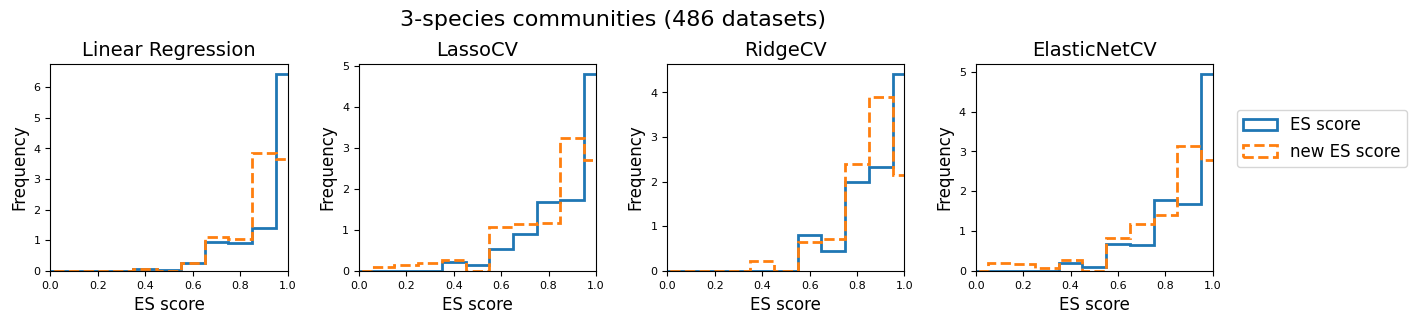

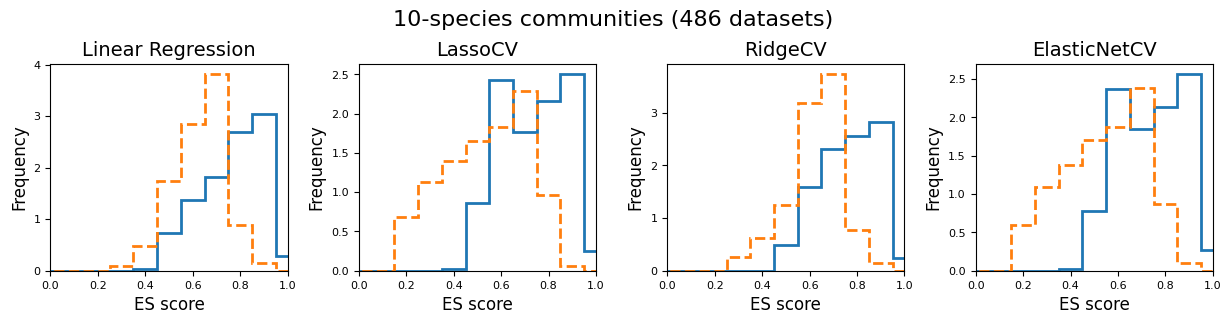

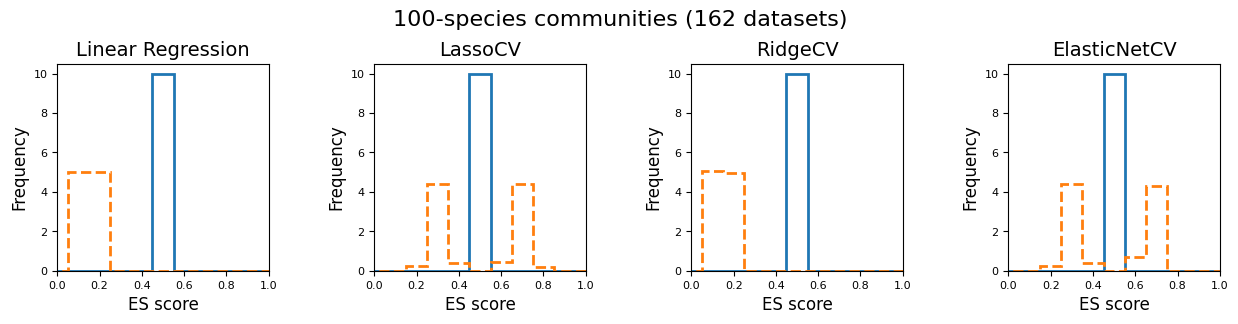

In [63]:
# plotting

n_bins = 10
bins = np.linspace(-0.05, 1.05, n_bins+2)

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    new_geom_df = new_geom_score_dfs[i]
    plt.subplot(1, 4, i+1)
    if i==3:
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True, label="ES score")
        plt.hist(new_geom_df[new_geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, ls="--", density=True, label="new ES score")
    else:
        plt.hist(geom_df[geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, density=True)
        plt.hist(new_geom_df[new_geom_df.n_sp==3].raw, bins=bins, histtype="step", lw=2, ls="--", density=True)

    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.legend(loc=(1.1,0.5), fontsize=12)
plt.show()

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    new_geom_df = new_geom_score_dfs[i]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_df[geom_df.n_sp==10].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(new_geom_df[new_geom_df.n_sp==10].raw, bins=bins, histtype="step", lw=2, ls="--", density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"10-species communities ({len(geom_df[geom_df.n_sp==10])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    new_geom_df = new_geom_score_dfs[i]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_df[geom_df.n_sp==100].raw, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(new_geom_df[new_geom_df.n_sp==100].raw, bins=bins, histtype="step", lw=2, ls="--", density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"100-species communities ({len(geom_df[geom_df.n_sp==100])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.5)
plt.show()

### ES score for floored inffered_aijs

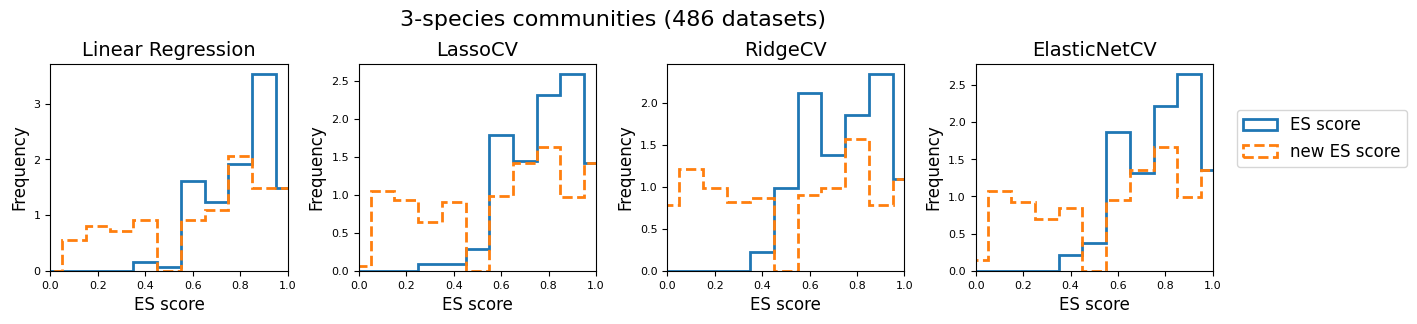

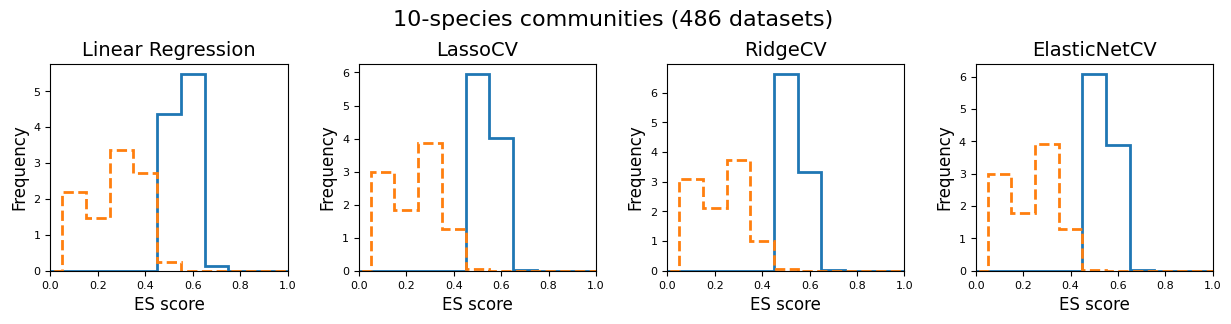

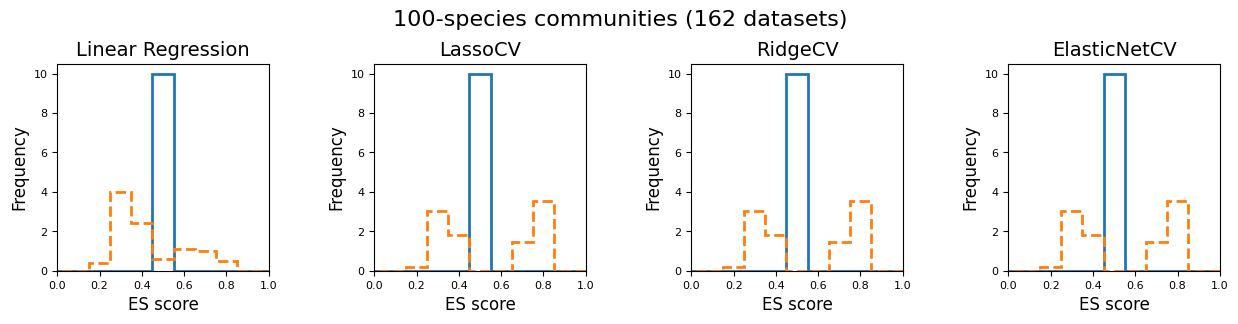

In [64]:
# plotting

n_bins = 10
bins = np.linspace(-0.05, 1.05, n_bins+2)

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    new_geom_df = new_geom_score_dfs[i]
    plt.subplot(1, 4, i+1)
    if i==3:
        plt.hist(geom_df[geom_df.n_sp==3].floored, bins=bins, histtype="step", lw=2, density=True, label="ES score")
        plt.hist(new_geom_df[new_geom_df.n_sp==3].floored, bins=bins, histtype="step", lw=2, ls="--", density=True, label="new ES score")
    else:
        plt.hist(geom_df[geom_df.n_sp==3].floored, bins=bins, histtype="step", lw=2, density=True)
        plt.hist(new_geom_df[new_geom_df.n_sp==3].floored, bins=bins, histtype="step", lw=2, ls="--", density=True)

    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"3-species communities ({len(geom_df[geom_df.n_sp==3])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.legend(loc=(1.1,0.5), fontsize=12)
plt.show()

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    new_geom_df = new_geom_score_dfs[i]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_df[geom_df.n_sp==10].floored, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(new_geom_df[new_geom_df.n_sp==10].floored, bins=bins, histtype="step", lw=2, ls="--", density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"10-species communities ({len(geom_df[geom_df.n_sp==10])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

plt.subplots(1, 4, figsize=(15,3))
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    new_geom_df = new_geom_score_dfs[i]
    plt.subplot(1, 4, i+1)
    plt.hist(geom_df[geom_df.n_sp==100].floored, bins=bins, histtype="step", lw=2, density=True)
    plt.hist(new_geom_df[new_geom_df.n_sp==100].floored, bins=bins, histtype="step", lw=2, ls="--", density=True)
    plt.xlim(0, 1)
    plt.xlabel("ES score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(reg_names[i], fontsize=14)
    # plt.yscale("log")
plt.suptitle(f"100-species communities ({len(geom_df[geom_df.n_sp==100])} datasets)", fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.5)
plt.show()

### Number of differences between the ES score and the `new_es_score` for **raw** inferred_aij's

In [65]:
print("For raw inferred_aij's:")
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    new_geom_df = new_geom_score_dfs[i]
    print(f"number of differences between ES score and new ES score - {reg_names[i]}: {(geom_df.raw.values!=new_geom_df.raw.values).sum()}")

For raw inferred_aij's:
number of differences between ES score and new ES score - Linear Regression: 810
number of differences between ES score and new ES score - LassoCV: 968
number of differences between ES score and new ES score - RidgeCV: 822
number of differences between ES score and new ES score - ElasticNetCV: 944


### Number of differences between the ES score and the `new_es_score` for **floored** inferred_aij's

In [66]:
print("For floored inferred_aij's:")
for i in range(len(geom_score_dfs)):
    geom_df = geom_score_dfs[i]
    new_geom_df = new_geom_score_dfs[i]
    print(f"number of differences between ES score and new ES score - {reg_names[i]}: {(geom_df.floored.values!=new_geom_df.floored.values).sum()}")

For floored inferred_aij's:
number of differences between ES score and new ES score - Linear Regression: 1061
number of differences between ES score and new ES score - LassoCV: 1065
number of differences between ES score and new ES score - RidgeCV: 1080
number of differences between ES score and new ES score - ElasticNetCV: 1068


We see a great difference between the two metrics, and flooring inferred_aij's doesn't really help it. 

The bimodality of the `new_es_score` for the 100-species communities is rather curious.

---

## Comparisons on randomly generated true_ij and inferred_aij pairs

Randomly create 10000 pairs of `true_aij` and `inferred_aij` matrices, with only **non-zero** interactions, and calculate both the ES score and the `new_es_score`

In [67]:
es_score = np.zeros(10000)
new_es_score = np.zeros(10000)

for i in tqdm(range(10000)):
    true_aij = np.random.normal(size=(10,10))
    inferred_aij = np.random.normal(size=(10,10))
    es_score[i] = calculate_es_score(true_aij, inferred_aij)
    new_es_score[i] = calculate_new_es_score(true_aij, inferred_aij)
    
print(f"Number of times ES score and new_es_score differ: {(es_score!=new_es_score).sum()}/10000")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.93it/s]

Number of times ES score and new_es_score differ: 0/10000


We can see that the definitions are equivalent for matrices without zeros. But what if we make the true matrix sparce? Let's do so by setting the smallest 30% of the interactions in randomly generated ground-truth to zero:

In [68]:
es_score = np.zeros(10000)
new_es_score = np.zeros(10000)

for i in tqdm(range(10000)):
    true_aij = np.random.normal(size=(10,10))
    true_aij[np.abs(true_aij) < np.percentile(np.abs(true_aij), 10)] = 0.
    inferred_aij = np.random.normal(size=(10,10))
    es_score[i] = calculate_es_score(true_aij, inferred_aij)
    new_es_score[i] = calculate_new_es_score(true_aij, inferred_aij)

print(f"Number of times ES score and new_es_score differ: {(es_score!=new_es_score).sum()}/10000")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:48<00:00, 206.00it/s]

Number of times ES score and new_es_score differ: 10000/10000


We can see all the results are different when we have matrices with zero-valued interactions!

We can even see how much the result changes as we increase the sparsity of the true interaction matrix:

In [69]:
es_score = np.zeros(100)
new_es_score = np.zeros(100)

avg_es_score_hist = np.zeros(100)
avg_new_es_score_hist = np.zeros(100)

for j in tqdm(range(100)):
    for i in range(100):
        np.random.seed(i)
        true_aij = np.random.normal(size=(10,10))
        true_aij[np.abs(true_aij) < np.percentile(np.abs(true_aij), j)] = 0.
        inferred_aij = np.random.normal(size=(10,10))
        es_score[i] = calculate_es_score(true_aij, inferred_aij)
        new_es_score[i] = calculate_new_es_score(true_aij, inferred_aij)
        
    avg_es_score_hist[j] = es_score.mean()
    avg_new_es_score_hist[j] = new_es_score.mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


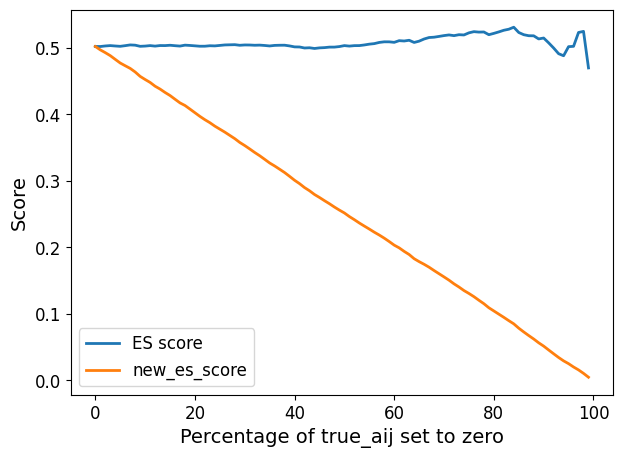

In [70]:
plt.figure(figsize=(7, 5))
plt.plot(avg_es_score_hist, lw=2, label="ES score")
plt.plot(avg_new_es_score_hist, lw=2, label="new_es_score")
plt.xlabel("Percentage of true_aij set to zero", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

This is to be expected as we are increasing the number of zeros in `true_aij` while still `inferred_aij` has no zeros in it. The original ES score only penalizes inferring a truly positive sign as a negative one and vice-versa, while the `new_es_score` also penalizes inferring a truly null interaction as a non-null one. In this sense, the `new_es_score` is clearer about the quality of the inference results, as it goes to zero when we fail to infer the sparsity of the interaction matrix.

### What would be the null model for inference?

Now that we have also the possibility of taking into account inferences of null interactions, we need a null model that consider this possibility. The simpler way to do it would be to have a family of null models indexed by the probability $ p $ of sorting interaction signs as 0. That is, we have a family of null models according to which an interaction sign $S$ is randomly sampled from a distribution

$$ \mathrm{P}\!\left( S \,|\, p \right) = \begin{cases}
                                  p, \; \text{if} \; S = 0; \\
                                  \left( 1-p \right)/2\; \text{if} \; S \in \left\{ -1, +1 \right\}.
                                  \end{cases}
$$

Starting from a known ground truth interaction matrix, one could use the proportion of zero and non-zero signs to sets $p$ for the null model. But, if one wishes to have a null model independent of $p$, one can attribute a probability distribution $\mathrm{F}\!\left( p \right)$ for this parameter, so that we have a final probability distribution of a sign $S$ to be

$$ \mathrm{P}\!\left( S \right) = \int\limits_{0}^{1} \mathrm{d}p \; \mathrm{F}\!\left( p \right) \mathrm{P}\!\left( S \,|\, p \right). $$

For example, if we assume $ p $ is uniformly distributed, we have:

$$ \mathrm{P}\!\left( S \right) = \int\limits_{0}^{1} \mathrm{d}p \; \mathrm{P}\!\left( S \,|\, p \right), $$

so that:

$$ \mathrm{P}\!\left( S=0 \right) = \int\limits_{0}^{1} \mathrm{d}p \; p = \frac{p^{2}}{2}\Bigg|_{0}^{1} = \frac{1}{2}, $$

and, obviously:

$$ \mathrm{P}\!\left( S=-1 \right) = \mathrm{P}\!\left( S=+1 \right) = \int\limits_{0}^{1} \mathrm{d}p \; \frac{1}{2} \left( 1 - p \right) = \frac{1}{2} \left( p - \frac{p^{2}}{2} \right)\Bigg|_{0}^{1} = \frac{1}{4}. $$

Of course this is a very simple model and I'm not suggesting we use it. It probably would be better to just use the $ p $ value obtained by the proportions of zero and non-zero signs in the ground truth interaction matrix.

Anyway, this is a simple example, analogue to the null model in the paper, but also considering the null interactions.

---

### A simpler definition for the original ES score - focusing only on truly non-zero interactions

I understand that someone could still be interested in looking only at the correctness of inferred signs of interactions known to be non-zero, and in this case it could be useful to have something similar to the original ES score, but it could be defined in a simpler way:

In [92]:
def calculate_new_es_score_non_zero_signs(true_aij, inferred_aij):
    masked_true_aij = true_aij[true_aij!=0]
    masked_inferred_aij = inferred_aij[true_aij!=0]
    
    return np.mean(np.sign(masked_true_aij)==np.sign(masked_inferred_aij))

In [96]:
es_score = np.zeros(10000)
new_es_score_non_zero_signs = np.zeros(10000)

for i in tqdm(range(10000)):
    true_aij = np.random.normal(size=(10,10))
    true_aij[np.abs(true_aij) < np.percentile(np.abs(true_aij), 10)] = 0.
    inferred_aij = np.random.normal(size=(10,10))
    es_score[i] = calculate_es_score(true_aij, inferred_aij)
    new_es_score_non_zero_signs[i] = calculate_new_es_score_non_zero_signs(true_aij, inferred_aij)

print(f"Number of times ES score and new_es_score_non_zero_signs differ: {(es_score!=new_es_score_non_zero_signs).sum()}/10000")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:47<00:00, 212.54it/s]

Number of times ES score and new_es_score_non_zero_signs differ: 0/10000


As you can see, `new_es_score_non_zero_signs` is equivalent to the original ES score, but with its definition is easier to understand.